<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# Quantization Aware Training YoloNAS on Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset from Hugging Face hub.

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from NVidia.

# Installations

In [1]:
!pip install -qq super-gradients==3.7.0 datasets[vision]~=2.1 pandas~=2.0

# Dataset Setup

In [2]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")

In [3]:
CLASS_NAMES = dataset["train"].features["objects"].feature["category"].names
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
from tqdm import tqdm
import cv2
import json
import os
import numpy as np


def convert_hf_to_coco(dataset_split, output_images_directory, output_annotation_json):
    class_names = dataset["train"].features["objects"].feature["category"].names

    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": name, "name": name, "id": category_id} for category_id, name in enumerate(class_names)],
    }

    os.makedirs(output_images_directory, exist_ok=True)

    annotation_id = 1

    for sample in tqdm(dataset_split):
        image_id = sample["image_id"]
        image = np.array(sample["image"])

        objects = sample["objects"]
        areas = objects["area"]
        bboxes = objects["bbox"]  # XYWH
        category_ids = objects["category"]

        for object_area, object_bbox, object_category in zip(areas, bboxes, category_ids):
            coco_annotation["annotations"].append(
                {
                    "id": annotation_id,
                    "category_id": object_category,
                    "area": float(object_area),
                    "iscrowd": 0,
                    "image_id": image_id,
                    "bbox": list(map(int, object_bbox)),
                }
            )
            annotation_id += 1

        filename = f"{image_id}.jpg"
        output_image_path = os.path.join(output_images_directory, filename)
        cv2.imwrite(output_image_path, image[..., ::-1])  # RGB to BGR

        coco_annotation["images"].append({"file_name": filename, "height": image.shape[0], "width": image.shape[1], "id": image_id})

    with open(output_annotation_json, "w") as f:
        json.dump(coco_annotation, f)


convert_hf_to_coco(dataset["train"], "cppe-5-coco/images/train", "cppe-5-coco/train_annotations.coco.json")
convert_hf_to_coco(dataset["test"], "cppe-5-coco/images/valid", "cppe-5-coco/valid_annotations.coco.json")

100%|██████████| 29/29 [00:00<00:00, 30.86it/s]


# Setup train and validation datasets

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for training our model.


In [5]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN

train_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/train",
    json_annotation_file="train_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(640, 640), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(640, 640)),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/valid",
    json_annotation_file="valid_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)

[2024-03-15 10:10:44] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into C:\Users\ekhve\sg_logs\console.log


[2024-03-15 10:10:44,955] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2024-03-15 10:10:49] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1000/1000 [00:00<00:00, 8588.00it/s]
[2024-03-15 10:10:49] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [6]:
from torch.utils.data import DataLoader

NUM_WORKERS = 0
BATCH_SIZE = 16

train_dataloader_params = {
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

# Defining training hyperparameters

In [7]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-5,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.5,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 1,
    "warmup_mode": "LinearEpochLRWarmup",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": False,
    "average_best_models": False,
    "ema_params": {"beta": 25, "decay_type": "exp"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}

# Instantiate YoloNAS model and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://cocodataset.org/#home).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [8]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models

trainer = Trainer(experiment_name="yolo_nas_s_cppe-5", ckpt_root_dir="experiments")
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, pretrained_weights="coco")
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

Indexing dataset annotations: 100%|██████████| 29/29 [00:00<00:00, 9667.37it/s]
[2024-03-15 10:10:50] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-03-15 10:10:50] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-15 10:10:50] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-03-15 1

The console stream is now moved to experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636/console_Mar15_10_10_50.txt


[2024-03-15 10:10:52] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Full dataset size:            1000       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         62         (len(train_loader))
    - Gradient updates per epoch:   62         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.14K parameters), WD: 0.0001, (18.98M parameters)

[2024-03-15 10:10:52] INFO - sg_trainer.py - Started training for 1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9125
│   ├── Ppyoloeloss/loss_iou = 0.5285
│   ├── Ppyoloeloss/loss_dfl = 0.6351
│   └── Ppyoloeloss/loss = 3.0761
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4263
    ├── Ppyoloeloss/loss_iou = 0.4397
    ├── Ppyoloeloss/loss_dfl = 0.4939
    ├── Ppyoloeloss/loss = 2.3599
    ├── Precision@0.50 = 0.1773
    ├── Recall@0.50 = 0.4911
    ├── Map@0.50 = 0.3985
    ├── F1@0.50 = 0.1919
    ├── Ap@0.50_coverall = 0.8444
    ├── Ap@0.50_face_shield = 0.2401
    ├── Ap@0.50_gloves = 0.311
    ├── Ap@0.50_goggles = 0.0
    ├── Ap@0.50_mask = 0.5967
    ├── Best_score_threshold = 0.4
    ├── Best_score_threshold_coverall = 0.4
    ├── Best_score_threshold_face_shield = 0.09
    ├── Best_score_threshold_gloves = 0.09
    ├── Best_score_threshold_goggles = 0.0
    └── Best_score_threshold_mask = 0.47



Validating epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
[2024-03-15 10:12:59] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:12:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4356427788734436
Train epoch 2:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1136
│   │   ├── Epoch N-1      = 1.9125 (↘ -0.7989)
│   │   └── Best until now = 1.9125 (↘ -0.7989)
│   ├── Ppyoloeloss/loss_iou = 0.595
│   │   ├── Epoch N-1      = 0.5285 (↗ 0.0666)
│   │   └── Best until now = 0.5285 (↗ 0.0666)
│   ├── Ppyoloeloss/loss_dfl = 0.6387
│   │   ├── Epoch N-1      = 0.6351 (↗ 0.0036)
│   │   └── Best until now = 0.6351 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 2.3474
│       ├── Epoch N-1      = 3.0761 (↘ -0.7288)
│       └── Best until now = 3.0761 (↘ -0.7288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3689
    │   ├── Epoch N-1      = 1.4263 (↘ -0.0573)
    │   └── Best until now = 1.4263 (↘ -0.0573)
    ├── Ppyoloeloss/loss_iou = 0.5573
    │   ├── Epoch N-1      = 0.4397 (↗ 0.1176)
    │   └── Best until now = 0.4397 (↗ 0.1176)
    ├── Ppyoloeloss/loss_dfl = 0.5791
    │   ├── Epoch N-1      = 0.4939 (↗ 0.0852)
    │   └── Best until now = 0.4939 (↗ 0.0852)
    ├── Ppyoloeloss/loss = 2.50

Validating epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]
[2024-03-15 10:14:00] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:14:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6274803280830383
Train epoch 3:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9777
│   │   ├── Epoch N-1      = 1.1136 (↘ -0.1359)
│   │   └── Best until now = 1.1136 (↘ -0.1359)
│   ├── Ppyoloeloss/loss_iou = 0.5502
│   │   ├── Epoch N-1      = 0.595  (↘ -0.0449)
│   │   └── Best until now = 0.5285 (↗ 0.0217)
│   ├── Ppyoloeloss/loss_dfl = 0.5983
│   │   ├── Epoch N-1      = 0.6387 (↘ -0.0405)
│   │   └── Best until now = 0.6351 (↘ -0.0369)
│   └── Ppyoloeloss/loss = 2.1262
│       ├── Epoch N-1      = 2.3474 (↘ -0.2212)
│       └── Best until now = 2.3474 (↘ -0.2212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9445
    │   ├── Epoch N-1      = 1.3689 (↘ -0.4244)
    │   └── Best until now = 1.3689 (↘ -0.4244)
    ├── Ppyoloeloss/loss_iou = 0.5265
    │   ├── Epoch N-1      = 0.5573 (↘ -0.0308)
    │   └── Best until now = 0.4397 (↗ 0.0868)
    ├── Ppyoloeloss/loss_dfl = 0.5188
    │   ├── Epoch N-1      = 0.5791 (↘ -0.0603)
    │   └── Best until now = 0.4939 (↗ 0.0249)
    ├── Ppyoloeloss/loss 

Validating epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9412
│   │   ├── Epoch N-1      = 0.9777 (↘ -0.0366)
│   │   └── Best until now = 0.9777 (↘ -0.0366)
│   ├── Ppyoloeloss/loss_iou = 0.5236
│   │   ├── Epoch N-1      = 0.5502 (↘ -0.0266)
│   │   └── Best until now = 0.5285 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.5705
│   │   ├── Epoch N-1      = 0.5983 (↘ -0.0278)
│   │   └── Best until now = 0.5983 (↘ -0.0278)
│   └── Ppyoloeloss/loss = 2.0352
│       ├── Epoch N-1      = 2.1262 (↘ -0.0909)
│       └── Best until now = 2.1262 (↘ -0.0909)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0918
    │   ├── Epoch N-1      = 0.9445 (↗ 0.1473)
    │   └── Best until now = 0.9445 (↗ 0.1473)
    ├── Ppyoloeloss/loss_iou = 0.5373
    │   ├── Epoch N-1      = 0.5265 (↗ 0.0108)
    │   └── Best until now = 0.4397 (↗ 0.0976)
    ├── Ppyoloeloss/loss_dfl = 0.5654
    │   ├── Epoch N-1      = 0.5188 (↗ 0.0465)
    │   └── Best until now = 0.4939 (↗ 0.0714)
    ├── Ppyoloeloss/loss = 2

Validating epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
[2024-03-15 10:16:15] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:16:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6629242300987244
Train epoch 5:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9145
│   │   ├── Epoch N-1      = 0.9412 (↘ -0.0267)
│   │   └── Best until now = 0.9412 (↘ -0.0267)
│   ├── Ppyoloeloss/loss_iou = 0.5127
│   │   ├── Epoch N-1      = 0.5236 (↘ -0.0109)
│   │   └── Best until now = 0.5236 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_dfl = 0.5626
│   │   ├── Epoch N-1      = 0.5705 (↘ -0.0079)
│   │   └── Best until now = 0.5705 (↘ -0.0079)
│   └── Ppyoloeloss/loss = 1.9897
│       ├── Epoch N-1      = 2.0352 (↘ -0.0455)
│       └── Best until now = 2.0352 (↘ -0.0455)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9919
    │   ├── Epoch N-1      = 1.0918 (↘ -0.0999)
    │   └── Best until now = 0.9445 (↗ 0.0473)
    ├── Ppyoloeloss/loss_iou = 0.4837
    │   ├── Epoch N-1      = 0.5373 (↘ -0.0536)
    │   └── Best until now = 0.4397 (↗ 0.044)
    ├── Ppyoloeloss/loss_dfl = 0.4979
    │   ├── Epoch N-1      = 0.5654 (↘ -0.0674)
    │   └── Best until now = 0.4939 (↗ 0.004)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]
[2024-03-15 10:17:23] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:17:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7218534350395203
Train epoch 6:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8823
│   │   ├── Epoch N-1      = 0.9145 (↘ -0.0322)
│   │   └── Best until now = 0.9145 (↘ -0.0322)
│   ├── Ppyoloeloss/loss_iou = 0.501
│   │   ├── Epoch N-1      = 0.5127 (↘ -0.0116)
│   │   └── Best until now = 0.5127 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_dfl = 0.5529
│   │   ├── Epoch N-1      = 0.5626 (↘ -0.0097)
│   │   └── Best until now = 0.5626 (↘ -0.0097)
│   └── Ppyoloeloss/loss = 1.9362
│       ├── Epoch N-1      = 1.9897 (↘ -0.0535)
│       └── Best until now = 1.9897 (↘ -0.0535)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9088
    │   ├── Epoch N-1      = 0.9919 (↘ -0.0831)
    │   └── Best until now = 0.9445 (↘ -0.0357)
    ├── Ppyoloeloss/loss_iou = 0.4872
    │   ├── Epoch N-1      = 0.4837 (↗ 0.0034)
    │   └── Best until now = 0.4397 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.5092
    │   ├── Epoch N-1      = 0.4979 (↗ 0.0113)
    │   └── Best until now = 0.4939 (↗ 0.0153)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
[2024-03-15 10:18:34] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:18:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7713503837585449
Train epoch 7:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.855
│   │   ├── Epoch N-1      = 0.8823 (↘ -0.0273)
│   │   └── Best until now = 0.8823 (↘ -0.0273)
│   ├── Ppyoloeloss/loss_iou = 0.4906
│   │   ├── Epoch N-1      = 0.501  (↘ -0.0105)
│   │   └── Best until now = 0.501  (↘ -0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.5377
│   │   ├── Epoch N-1      = 0.5529 (↘ -0.0151)
│   │   └── Best until now = 0.5529 (↘ -0.0151)
│   └── Ppyoloeloss/loss = 1.8833
│       ├── Epoch N-1      = 1.9362 (↘ -0.0529)
│       └── Best until now = 1.9362 (↘ -0.0529)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8443
    │   ├── Epoch N-1      = 0.9088 (↘ -0.0645)
    │   └── Best until now = 0.9088 (↘ -0.0645)
    ├── Ppyoloeloss/loss_iou = 0.4506
    │   ├── Epoch N-1      = 0.4872 (↘ -0.0366)
    │   └── Best until now = 0.4397 (↗ 0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.4754
    │   ├── Epoch N-1      = 0.5092 (↘ -0.0338)
    │   └── Best until now = 0.4939 (↘ -0.0185)
    ├── Ppyoloeloss/loss

Validating epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8437
│   │   ├── Epoch N-1      = 0.855  (↘ -0.0112)
│   │   └── Best until now = 0.855  (↘ -0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.4907
│   │   ├── Epoch N-1      = 0.4906 (↗ 1e-04)
│   │   └── Best until now = 0.4906 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5389
│   │   ├── Epoch N-1      = 0.5377 (↗ 0.0012)
│   │   └── Best until now = 0.5377 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.8733
│       ├── Epoch N-1      = 1.8833 (↘ -0.01)
│       └── Best until now = 1.8833 (↘ -0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8787
    │   ├── Epoch N-1      = 0.8443 (↗ 0.0344)
    │   └── Best until now = 0.8443 (↗ 0.0344)
    ├── Ppyoloeloss/loss_iou = 0.4621
    │   ├── Epoch N-1      = 0.4506 (↗ 0.0115)
    │   └── Best until now = 0.4397 (↗ 0.0223)
    ├── Ppyoloeloss/loss_dfl = 0.4972
    │   ├── Epoch N-1      = 0.4754 (↗ 0.0218)
    │   └── Best until now = 0.4754 (↗ 0.0218)
    ├── Ppyoloeloss/loss = 1.838
    │

Validating epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]
[2024-03-15 10:20:48] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:20:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7790321111679077
Train epoch 9:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8334
│   │   ├── Epoch N-1      = 0.8437 (↘ -0.0103)
│   │   └── Best until now = 0.8437 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.4772
│   │   ├── Epoch N-1      = 0.4907 (↘ -0.0135)
│   │   └── Best until now = 0.4906 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_dfl = 0.5244
│   │   ├── Epoch N-1      = 0.5389 (↘ -0.0145)
│   │   └── Best until now = 0.5377 (↘ -0.0134)
│   └── Ppyoloeloss/loss = 1.835
│       ├── Epoch N-1      = 1.8733 (↘ -0.0384)
│       └── Best until now = 1.8733 (↘ -0.0384)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8631
    │   ├── Epoch N-1      = 0.8787 (↘ -0.0156)
    │   └── Best until now = 0.8443 (↗ 0.0188)
    ├── Ppyoloeloss/loss_iou = 0.442
    │   ├── Epoch N-1      = 0.4621 (↘ -0.0201)
    │   └── Best until now = 0.4397 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.4672
    │   ├── Epoch N-1      = 0.4972 (↘ -0.03)
    │   └── Best until now = 0.4754 (↘ -0.0082)
    ├── Ppyoloeloss/loss = 1

Validating epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]



# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [9]:
best_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
regular_metrics = trainer.test(model=best_model, test_loader=valid_loader)
regular_metrics

[2024-03-15 10:21:55] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth
[2024-03-15 10:21:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8216230273246765
[2024-03-15 10:21:55] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8152
│   │   ├── Epoch N-1      = 0.8334 (↘ -0.0183)
│   │   └── Best until now = 0.8334 (↘ -0.0183)
│   ├── Ppyoloeloss/loss_iou = 0.4716
│   │   ├── Epoch N-1      = 0.4772 (↘ -0.0056)
│   │   └── Best until now = 0.4772 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.5164
│   │   ├── Epoch N-1      = 0.5244 (↘ -0.0079)
│   │   └── Best until now = 0.5244 (↘ -0.0079)
│   └── Ppyoloeloss/loss = 1.8032
│       ├── Epoch N-1      = 1.835  (↘ -0.0318)
│       └── Best until now = 1.835  (↘ -0.0318)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8293
    │   ├── Epoch N-1      = 0.8631 (↘ -0.0338)
    │   └── Best until now = 0.8443 (↘ -0.015)
    ├── Ppyoloeloss/loss_iou = 0.4506
    │   ├── Epoch N-1      = 0.442  (↗ 0.0086)
    │   └── Best until now = 0.4397 (↗ 0.0108)
    ├── Ppyoloeloss/loss_dfl = 0.4698
    │   ├── Epoch N-1      = 0.4672 (↗ 0.0026)
    │   └── Best until now = 0.4672 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 

[2024-03-15 10:21:56] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth checkpoint.
Testing:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s]

{'PPYoloELoss/loss_cls': 0.82930285,
 'PPYoloELoss/loss_iou': 0.4505622,
 'PPYoloELoss/loss_dfl': 0.46977165,
 'PPYoloELoss/loss': 1.7496367,
 'Precision@0.50': 0.155705988407135,
 'Recall@0.50': 0.8956758379936218,
 'mAP@0.50': 0.8216230273246765,
 'F1@0.50': 0.26202842593193054,
 'AP@0.50_Coverall': 0.8299552798271179,
 'AP@0.50_Face_Shield': 0.9544829726219177,
 'AP@0.50_Gloves': 0.7184129357337952,
 'AP@0.50_Goggles': 0.7598097920417786,
 'AP@0.50_Mask': 0.8454539775848389,
 'Best_score_threshold': 0.3999999761581421,
 'Best_score_threshold_Coverall': 0.41999998688697815,
 'Best_score_threshold_Face_Shield': 0.4399999976158142,
 'Best_score_threshold_Gloves': 0.23999999463558197,
 'Best_score_threshold_Goggles': 0.28999999165534973,
 'Best_score_threshold_Mask': 0.44999998807907104}

Testing: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


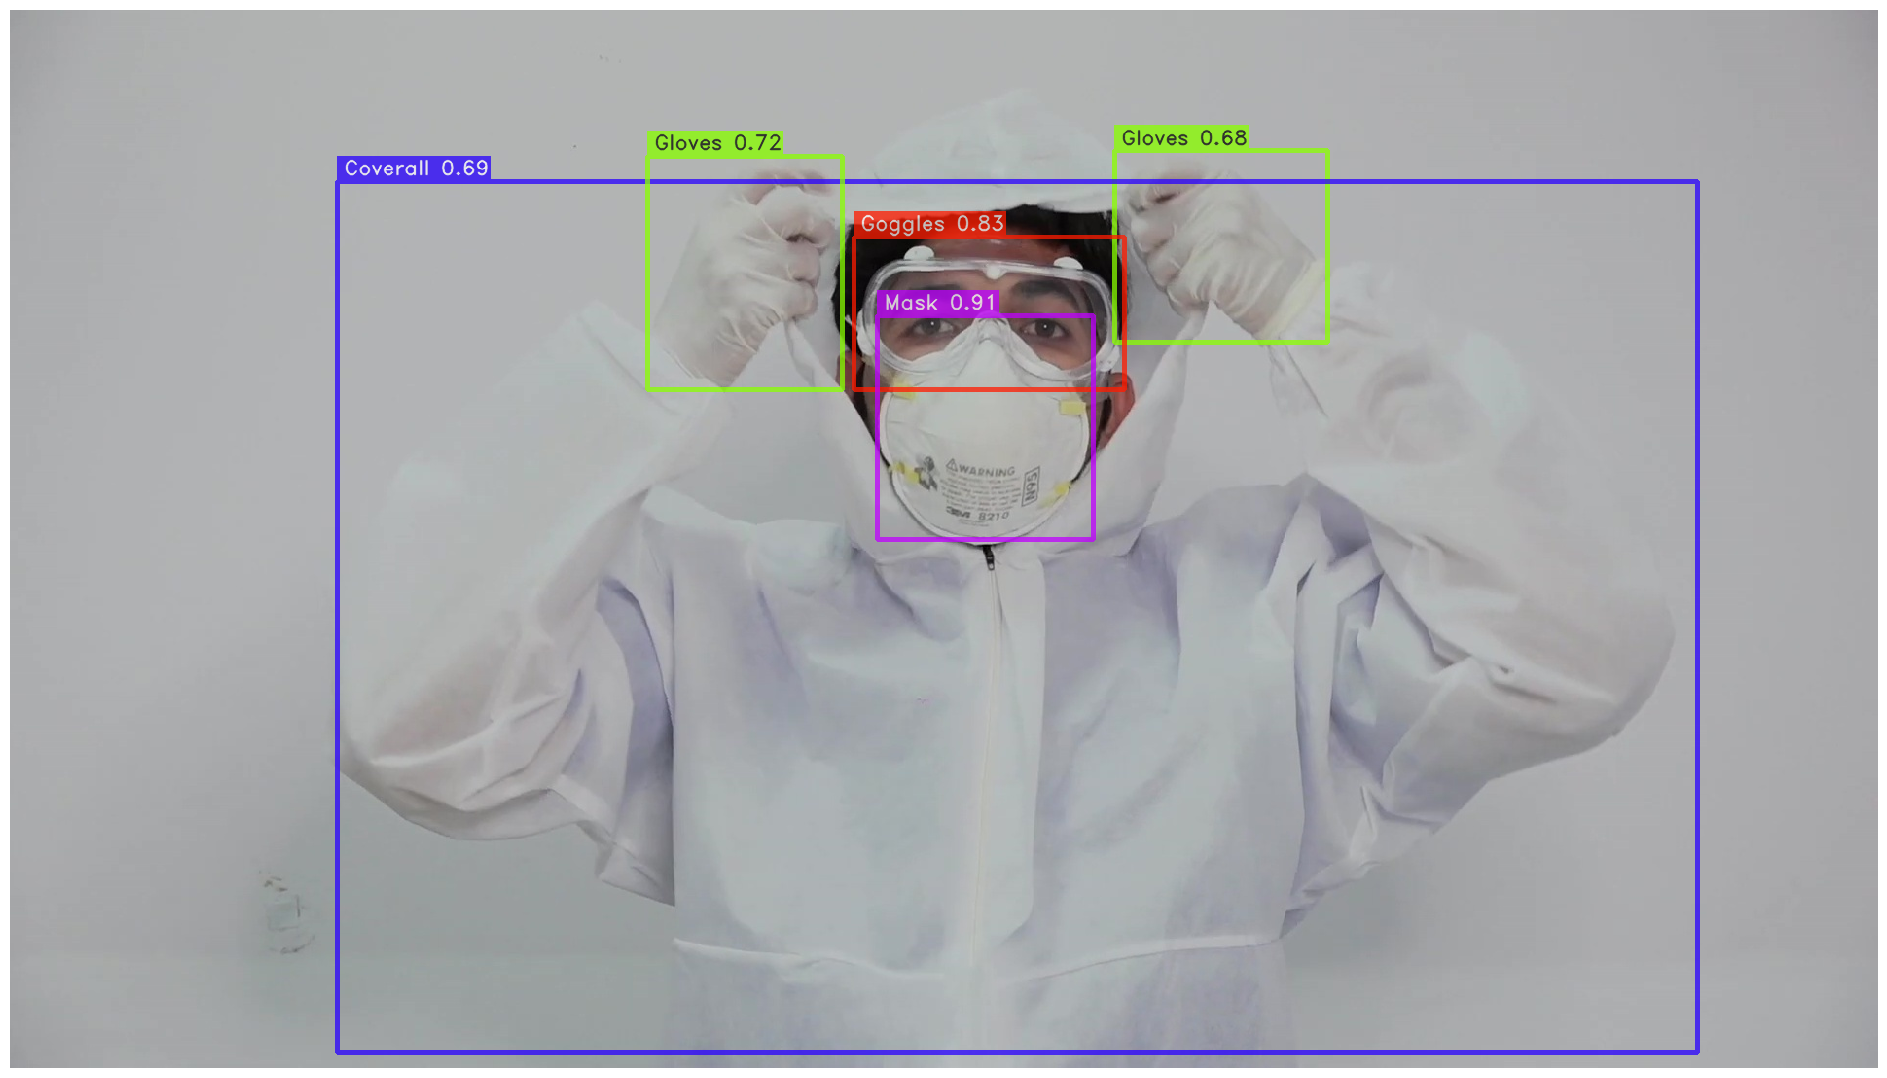

In [10]:
prediction = best_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Post-training quantization

We will now perform post-training quantization (PTQ) on our best model. 
This will result in a quantized model that can be used on hardware that supports INT8 operations.

A post-training quantization process is performed by the `ptq` method of the `Trainer` class. 
It converts the model's weights to INT8 and performs model calibration to minimize the accuracy loss. 
The calibration is done using a calibration data loader (`calib_loader`). 

To evalute the quantized model, we use the `valid_loader` parameter to specify the dataloader for validation. 
In this case, we use the same dataloader as we used during regular training to have apples-to-apples comparison.

Quantization is a last step before model deployment. So after PTQ we usually want to export the model to ONNX format, which is a common format for deployment.
The `export_params` parameter is used to specify the various arguments like batch size, whether pre- or post-processing should be applied, etc.
For example, if we set `preprocessing=True` and `postprocessing=True` so our detection model will take `uint8` RGB images and output detections after the NMS.

In [11]:
best_model_checkpoint_path = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")
best_model_checkpoint_path

'experiments\\yolo_nas_s_cppe-5\\RUN_20240315_101050_835636\\ckpt_best.pth'

In [12]:
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=best_model_checkpoint_path)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)

ptq_result = trainer.ptq(model=best_model, calib_loader=valid_loader, valid_loader=valid_loader, export_params=export_params)
ptq_metrics = ptq_result.valid_metrics_dict

[2024-03-15 10:22:00] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments\yolo_nas_s_cppe-5\RUN_20240315_101050_835636\ckpt_best.pth checkpoint.
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
W0315 10:22:11.777420 11412 tensor_quantizer.py:281] Use Pytorch's native experimental fake quantization.
C:\Users\ekhve\.conda\envs\kaggle\lib\site-packages\pytorch_quantization\nn\modules\tensor_quantizer.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
C:\Users\ekhve\.conda\envs\kaggle\lib\site-packages\pytorch_quantization\nn\modules\tensor_quantizer.py:286: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will

### Inspect metrics of model after PTQ

In [13]:
ptq_metrics

{'PPYoloELoss/loss_cls': 0.8296542,
 'PPYoloELoss/loss_iou': 0.452731,
 'PPYoloELoss/loss_dfl': 0.47151092,
 'PPYoloELoss/loss': 1.7538961,
 'Precision@0.50': 0.15055446326732635,
 'Recall@0.50': 0.9024932980537415,
 'mAP@0.50': 0.8270365595817566,
 'F1@0.50': 0.25500524044036865,
 'AP@0.50_Coverall': 0.8309770822525024,
 'AP@0.50_Face_Shield': 0.9561773538589478,
 'AP@0.50_Gloves': 0.7146286368370056,
 'AP@0.50_Goggles': 0.7707217335700989,
 'AP@0.50_Mask': 0.8626778721809387,
 'Best_score_threshold': 0.3799999952316284,
 'Best_score_threshold_Coverall': 0.41999998688697815,
 'Best_score_threshold_Face_Shield': 0.3799999952316284,
 'Best_score_threshold_Gloves': 0.2199999988079071,
 'Best_score_threshold_Goggles': 0.2800000011920929,
 'Best_score_threshold_Mask': 0.38999998569488525}

### Pretict with PTQ model

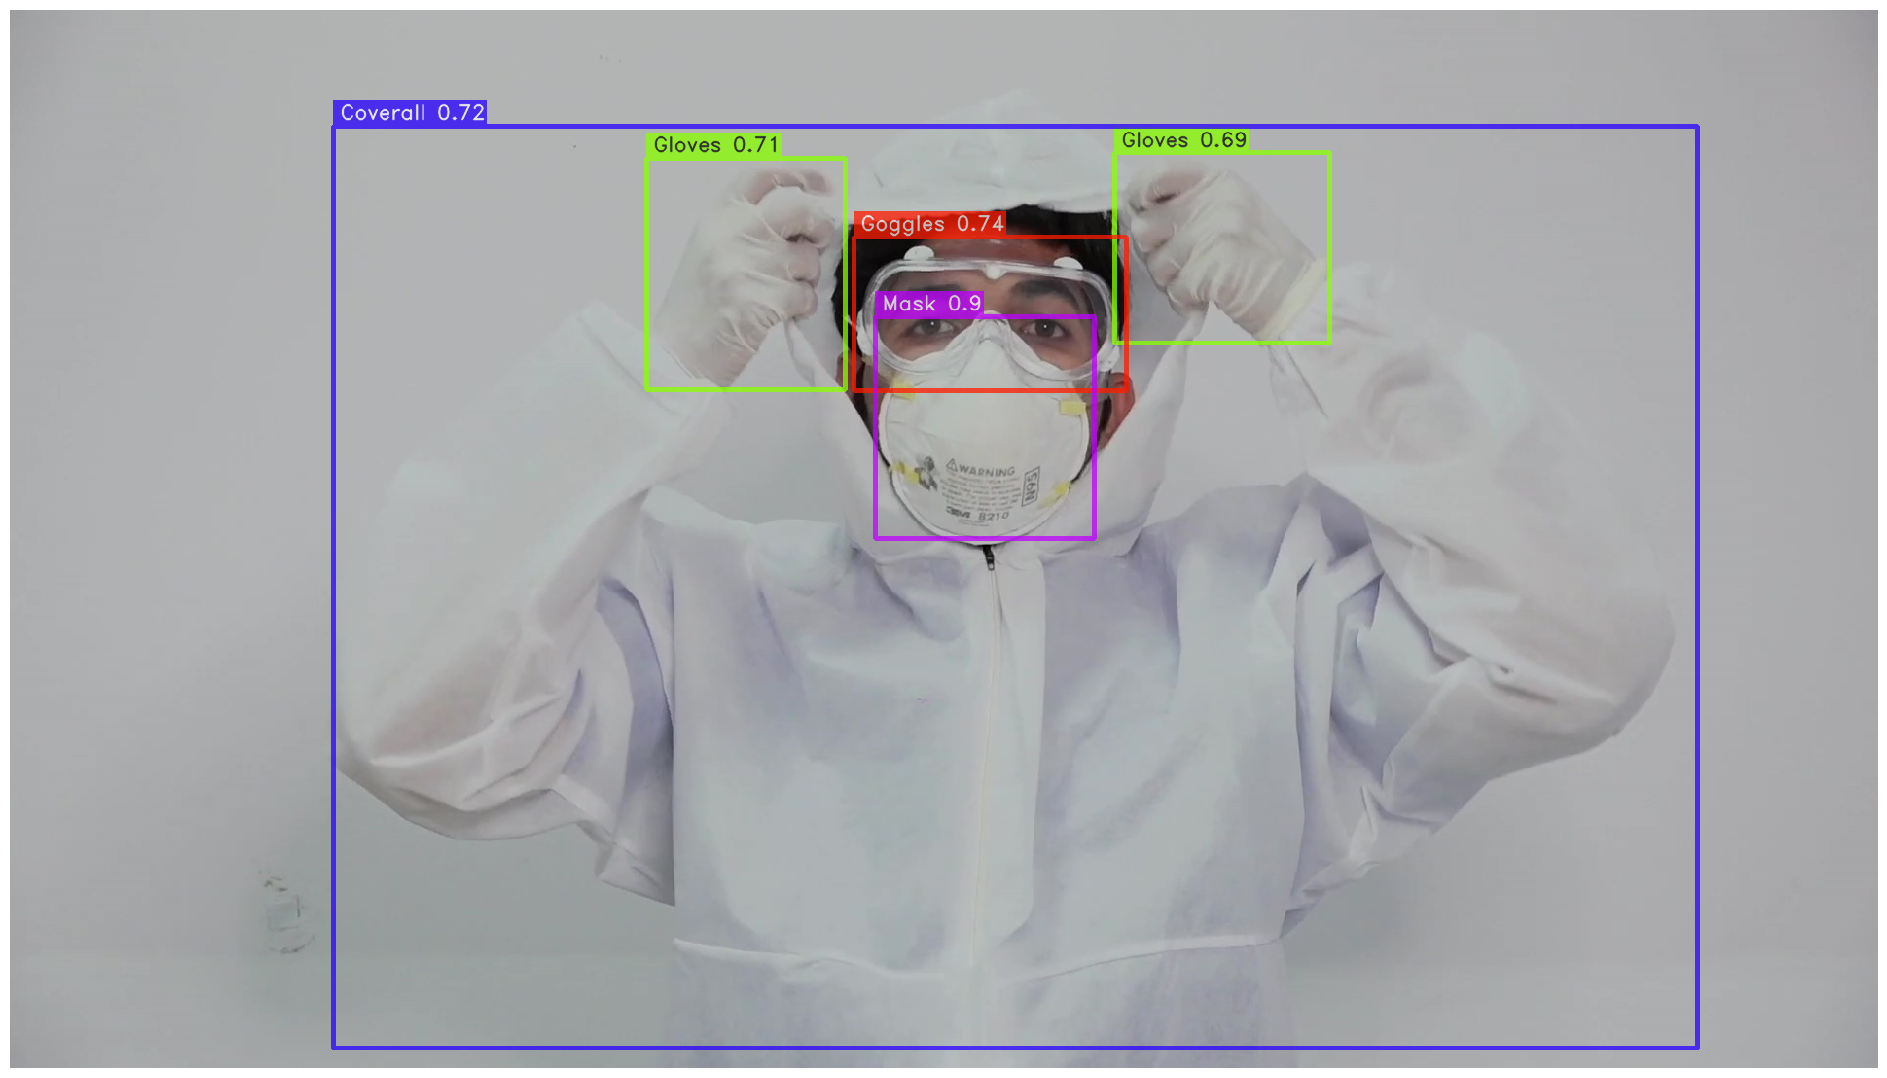

In [14]:
prediction = ptq_result.quantized_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Quantization-aware training

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset. 
All manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format. 
- The exported PTQ model is saved under our checkpoints directory.
- Finally, we perform quantization aware training with our adapted training parameters - since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [15]:
import os
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=best_model_checkpoint_path)

qat_train_params, qat_train_dataset_params, qat_valid_dataset_params, qat_train_dataloader_params, qat_val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, valid_dataset_params, train_dataloader_params, val_dataloader_params, max_epochs_divisor=2
)

qat_trainset = COCOFormatDetectionDataset(**qat_train_dataset_params)
qat_valset = COCOFormatDetectionDataset(**qat_valid_dataset_params)

qat_train_loader = DataLoader(qat_trainset, **qat_train_dataloader_params)
qat_valid_loader = DataLoader(qat_valset, **qat_val_dataloader_params)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)
qat_trainer = Trainer(experiment_name="yolo_nas_s_cppe-5_qat", ckpt_root_dir="experiments")
qat_result = qat_trainer.qat(
    model=best_model,
    training_params=qat_train_params,
    train_loader=qat_train_loader,
    valid_loader=qat_valid_loader,
    calib_loader=qat_valid_loader,
    export_params=export_params,
)

W0315 10:22:31.036642 11412 pre_launch_callbacks.py:293] New number of epochs: 5
W0315 10:22:31.036642 11412 pre_launch_callbacks.py:300] New learning rate: 5e-06
W0315 10:22:31.036642 11412 pre_launch_callbacks.py:301] New weight decay: 1.0000000000000002e-06
W0315 10:22:31.036642 11412 pre_launch_callbacks.py:306] lr_mode will be set to cosine for QAT run instead of CosineLRScheduler with cosine_final_lr_ratio=0.01
W0315 10:22:31.036642 11412 pre_launch_callbacks.py:312] New lr_warmup_epochs: 1
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


The console stream is now moved to experiments\yolo_nas_s_cppe-5_qat\RUN_20240315_102240_863406/console_Mar15_10_22_40.txt


[2024-03-15 10:22:42] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Full dataset size:            1000       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         62         (len(train_loader))
    - Gradient updates per epoch:   62         (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (12.15M parameters, 12.15M optimized)
    - Learning Rates and Weight Decays:
      - default: (12.15M parameters). LR: 5e-06 (12.15M parameters) WD: 0.0, (29.61K parameters), WD: 1.0000000000000002e-06, (12.12M parameters)

[2024-03-15 10:22:42] INFO - sg_trainer.py - Started

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8028
│   ├── Ppyoloeloss/loss_iou = 0.4607
│   ├── Ppyoloeloss/loss_dfl = 0.5069
│   └── Ppyoloeloss/loss = 1.7704
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7857
    ├── Ppyoloeloss/loss_iou = 0.4411
    ├── Ppyoloeloss/loss_dfl = 0.4582
    ├── Ppyoloeloss/loss = 1.6851
    ├── Precision@0.50 = 0.1446
    ├── Recall@0.50 = 0.9403
    ├── Map@0.50 = 0.8639
    ├── F1@0.50 = 0.2492
    ├── Ap@0.50_coverall = 0.8515
    ├── Ap@0.50_face_shield = 0.9761
    ├── Ap@0.50_gloves = 0.7995
    ├── Ap@0.50_goggles = 0.8077
    ├── Ap@0.50_mask = 0.8848
    ├── Best_score_threshold = 0.37
    ├── Best_score_threshold_coverall = 0.46
    ├── Best_score_threshold_face_shield = 0.39
    ├── Best_score_threshold_gloves = 0.31
    ├── Best_score_threshold_goggles = 0.27
    └── Best_score_threshold_mask = 0.37



Validating epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]
[2024-03-15 10:25:31] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5_qat\RUN_20240315_102240_863406\ckpt_best.pth
[2024-03-15 10:25:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8772150278091431
Train epoch 2:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7891
│   │   ├── Epoch N-1      = 0.8028 (↘ -0.0137)
│   │   └── Best until now = 0.8028 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.4448
│   │   ├── Epoch N-1      = 0.4607 (↘ -0.0158)
│   │   └── Best until now = 0.4607 (↘ -0.0158)
│   ├── Ppyoloeloss/loss_dfl = 0.4977
│   │   ├── Epoch N-1      = 0.5069 (↘ -0.0092)
│   │   └── Best until now = 0.5069 (↘ -0.0092)
│   └── Ppyoloeloss/loss = 1.7317
│       ├── Epoch N-1      = 1.7704 (↘ -0.0387)
│       └── Best until now = 1.7704 (↘ -0.0387)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7592
    │   ├── Epoch N-1      = 0.7857 (↘ -0.0265)
    │   └── Best until now = 0.7857 (↘ -0.0265)
    ├── Ppyoloeloss/loss_iou = 0.416
    │   ├── Epoch N-1      = 0.4411 (↘ -0.0252)
    │   └── Best until now = 0.4411 (↘ -0.0252)
    ├── Ppyoloeloss/loss_dfl = 0.4426
    │   ├── Epoch N-1      = 0.4582 (↘ -0.0156)
    │   └── Best until now = 0.4582 (↘ -0.0156)
    ├── Ppyoloeloss/los

Validating epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
[2024-03-15 10:26:54] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5_qat\RUN_20240315_102240_863406\ckpt_best.pth
[2024-03-15 10:26:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8839054107666016
Train epoch 3:   0%|          | 0/62 [00:00<?, ?it/s]

SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7751
│   │   ├── Epoch N-1      = 0.7891 (↘ -0.0139)
│   │   └── Best until now = 0.7891 (↘ -0.0139)
│   ├── Ppyoloeloss/loss_iou = 0.4376
│   │   ├── Epoch N-1      = 0.4448 (↘ -0.0072)
│   │   └── Best until now = 0.4448 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.4964
│   │   ├── Epoch N-1      = 0.4977 (↘ -0.0013)
│   │   └── Best until now = 0.4977 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.7092
│       ├── Epoch N-1      = 1.7317 (↘ -0.0225)
│       └── Best until now = 1.7317 (↘ -0.0225)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7547
    │   ├── Epoch N-1      = 0.7592 (↘ -0.0045)
    │   └── Best until now = 0.7592 (↘ -0.0045)
    ├── Ppyoloeloss/loss_iou = 0.4097
    │   ├── Epoch N-1      = 0.416  (↘ -0.0063)
    │   └── Best until now = 0.416  (↘ -0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.4394
    │   ├── Epoch N-1      = 0.4426 (↘ -0.0032)
    │   └── Best until now = 0.4426 (↘ -0.0032)
    ├── Ppyoloeloss/lo

Validating epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.766
│   │   ├── Epoch N-1      = 0.7751 (↘ -0.0092)
│   │   └── Best until now = 0.7751 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.4314
│   │   ├── Epoch N-1      = 0.4376 (↘ -0.0062)
│   │   └── Best until now = 0.4376 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.4873
│   │   ├── Epoch N-1      = 0.4964 (↘ -0.0092)
│   │   └── Best until now = 0.4964 (↘ -0.0092)
│   └── Ppyoloeloss/loss = 1.6846
│       ├── Epoch N-1      = 1.7092 (↘ -0.0246)
│       └── Best until now = 1.7092 (↘ -0.0246)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7506
    │   ├── Epoch N-1      = 0.7547 (↘ -0.0041)
    │   └── Best until now = 0.7547 (↘ -0.0041)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.4097 (↘ -0.0016)
    │   └── Best until now = 0.4097 (↘ -0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.4386
    │   ├── Epoch N-1      = 0.4394 (↘ -0.0008)
    │   └── Best until now = 0.4394 (↘ -0.0008)
    ├── Ppyoloeloss/loss

Validating epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]
[2024-03-15 10:29:24] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5_qat\RUN_20240315_102240_863406\ckpt_best.pth
[2024-03-15 10:29:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.884486198425293
[2024-03-15 10:29:24] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing:   0%|          | 0/2 [00:00<?, ?it/s]

SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7631
│   │   ├── Epoch N-1      = 0.766  (↘ -0.0029)
│   │   └── Best until now = 0.766  (↘ -0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.4308
│   │   ├── Epoch N-1      = 0.4314 (↘ -0.0006)
│   │   └── Best until now = 0.4314 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.4885
│   │   ├── Epoch N-1      = 0.4873 (↗ 0.0012)
│   │   └── Best until now = 0.4873 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.6824
│       ├── Epoch N-1      = 1.6846 (↘ -0.0022)
│       └── Best until now = 1.6846 (↘ -0.0022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7505
    │   ├── Epoch N-1      = 0.7506 (↘ -0.0)
    │   └── Best until now = 0.7506 (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.4087
    │   ├── Epoch N-1      = 0.408  (↗ 0.0007)
    │   └── Best until now = 0.408  (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.4389
    │   ├── Epoch N-1      = 0.4386 (↗ 0.0003)
    │   └── Best until now = 0.4386 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 1.5981


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


### Inspect metrics of model after QAT

In [16]:
qat_metrics = qat_result.valid_metrics_dict
qat_metrics

{'PPYoloELoss/loss_cls': 0.7505409,
 'PPYoloELoss/loss_iou': 0.40869012,
 'PPYoloELoss/loss_dfl': 0.43891633,
 'PPYoloELoss/loss': 1.5981472,
 'Precision@0.50': 0.13478434085845947,
 'Recall@0.50': 0.9545561671257019,
 'mAP@0.50': 0.884486198425293,
 'F1@0.50': 0.2341063916683197,
 'AP@0.50_Coverall': 0.8717945218086243,
 'AP@0.50_Face_Shield': 0.9770626425743103,
 'AP@0.50_Gloves': 0.8230339288711548,
 'AP@0.50_Goggles': 0.8560429215431213,
 'AP@0.50_Mask': 0.8944970965385437,
 'Best_score_threshold': 0.4099999964237213,
 'Best_score_threshold_Coverall': 0.4699999988079071,
 'Best_score_threshold_Face_Shield': 0.4099999964237213,
 'Best_score_threshold_Gloves': 0.429999977350235,
 'Best_score_threshold_Goggles': 0.35999998450279236,
 'Best_score_threshold_Mask': 0.3799999952316284}

### Predict with QAT model

[2024-03-15 10:29:40] INFO - sg_trainer.py - Exported QAT ONNX to experiments\yolo_nas_s_cppe-5_qat\yolo_nas_s_cppe-5_qat_1x3x640x640_qat.onnx


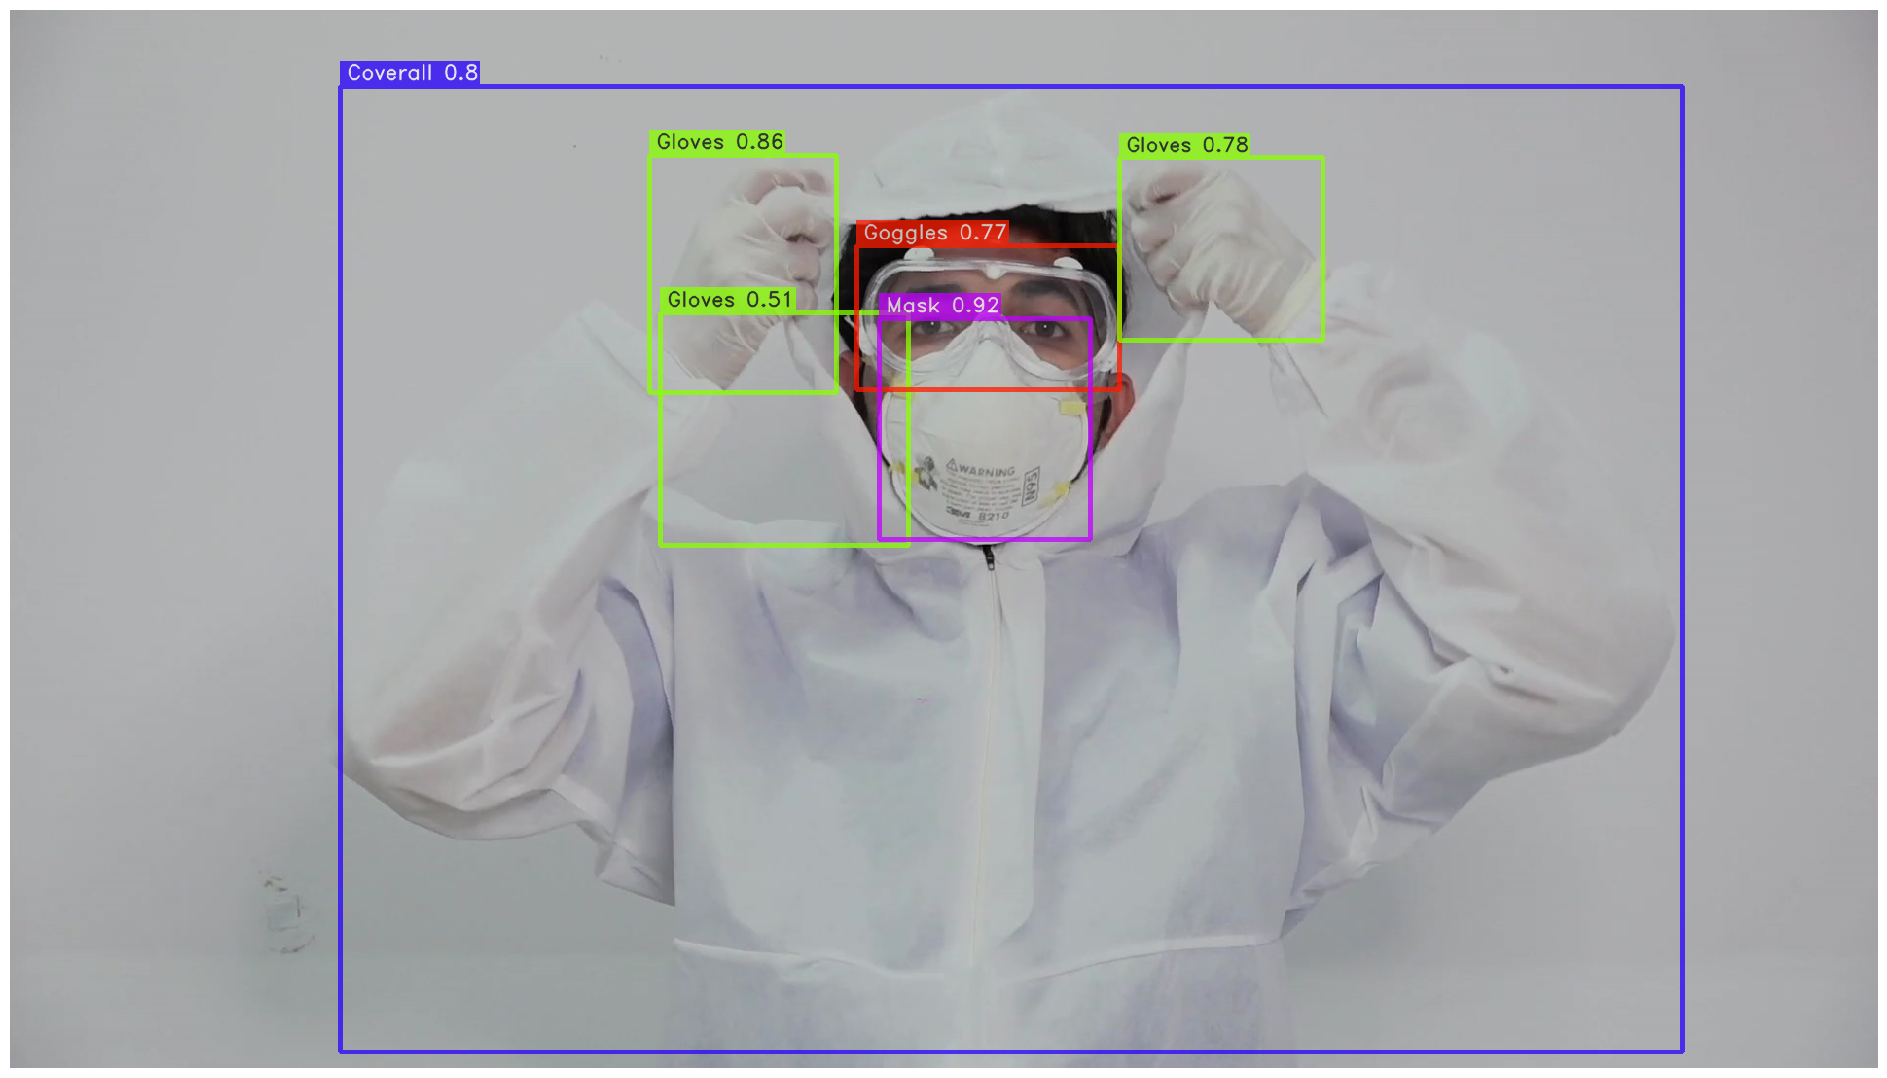

In [17]:
prediction = qat_result.quantized_model.predict(dataset["test"][0]["image"], fuse_model=False)
prediction.show()

# Inference using exported ONNX model

Once QAT is done, we export the model to ONNX format and now it is ready for deployment.
In this example we will use ONNXRuntime to load the model and run inference on a single image.

We can explore the `qat_result.export_result` property to see the details of the exported model and code snippet
to run inference using the exported model: 


In [18]:
qat_result.export_result

Model exported successfully to experiments\yolo_nas_s_cppe-5_qat\yolo_nas_s_cppe-5_qat_1x3x640x640_qat.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("expe

An end-to-end example of how to run inference using the exported model is shown below.

**Please keep in mind this is a simple example. We do cut corners here to keep notebook of reasonable size:**

* Batch size is set to 1.
* In a real-world scenario you would want to batch your inference requests to get the best performance from your model.
* Image preprocessing resize image to 640x640 without preserving aspec ratio

C:\Users\ekhve\.conda\envs\kaggle\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


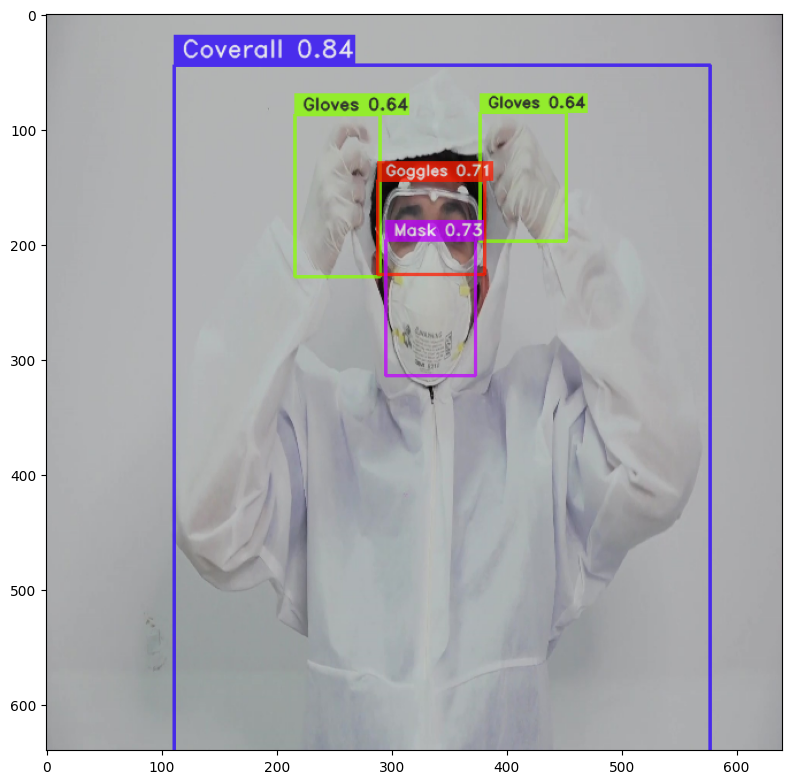

In [19]:
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.utils.media.image import load_image
import onnxruntime
import numpy as np

import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format


def show_predictions_from_batch_format(image, predictions):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(image_np=np.array(image), class_names=CLASS_NAMES, pred_boxes=predicted_boxes)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


session = onnxruntime.InferenceSession(qat_result.output_onnx_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]

image = load_image(dataset["test"][0]["image"])
image = cv2.resize(image, (640, 640))

input_image = np.moveaxis(image, -1, 0)
input_image = np.expand_dims(input_image, axis=0)
predictions = session.run(outputs, {inputs[0]: input_image})

show_predictions_from_batch_format(image, predictions)

# Summary


If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

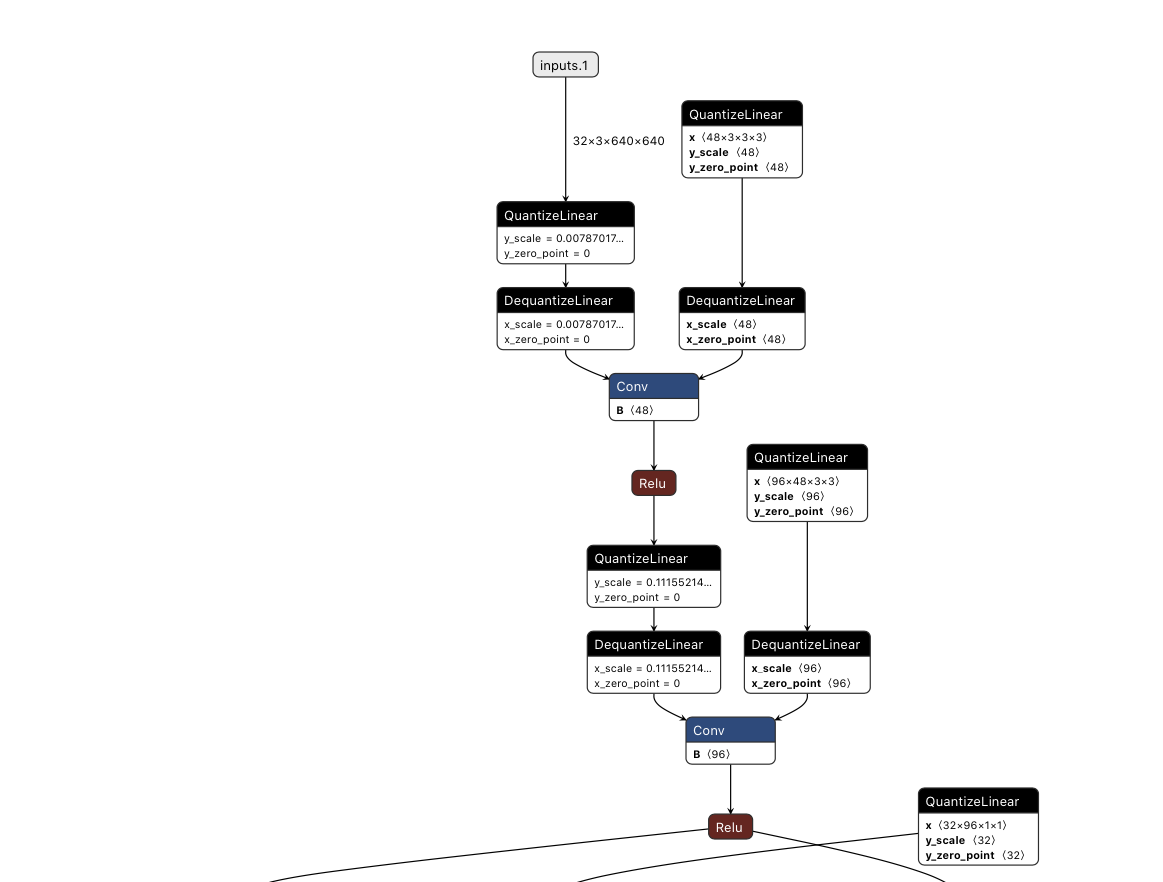

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).